## Comparing and Evaluating Clustering Algorithms

One of the challenges in applying clustering algorithms is that it is very hard to assess how well an algorithm worked, and to compare outcomes between different algorithms. After talking about the algorithms behind k-means, agglomerative clustering, and DBSCAN, we will now compare them on some real-world datasets.

### Evaluating Clustering with Ground Truth

There are metrics that can be used to assess the outcome of a clustering algorithm relative to a ground truth clustering, the most important ones being the *adjusted rand index (ARI)* and *normalized mutual information (NMI)*, which both provide a quantitative measure with an optimum of 1 and a value of 0 for unrelated clusterings (though the ARI can become negative).

Here, we compare the k-means, agglomerative clustering, and DBSCAN algorithms using ARI. We also include what it looks like when we randomly assign points to two clusters for comparison:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_moons

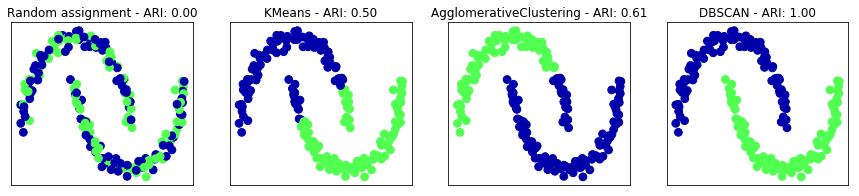

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

The adjusted rand index provides intuitive results, with a random cluster assignment having a score of 0 and DBSCAN (which recovers the desired clustering perfectly) having a score of 1.

A common mistake when evaluating clustering in this way is to use *accuracy_score* instead of *adjusted_rand_score*, *normalized_mutual_info_score*, or some other clustering metric. The problem in using accuracy is that it requires the assigned cluster labels to exactly match the ground truth. However, the cluster labels themselves are meaningless—the only thing that matters is which points are in the same cluster:

In [4]:
from sklearn.metrics import accuracy_score

# These two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]

# Accuracy is zero, as none of the labels are the same
print("Accuracy: {:.2f}".format(accuracy_score(clusters1, clusters2)))

# Adjusted rand score is 1, as the clustering is exactly the same
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Accuracy: 0.00
ARI: 1.00


### Evaluating Clustering Without Ground Truth

Although we have just shown one way to evaluate clustering algorithms, in practice, there is a big problem with using measures like ARI. When applying clustering algorithms, there is usually no ground truth to which to compare the results. If we knew the right clustering of the data, we could use this information to build a supervised model like a classifier. Therefore, using metrics like ARI and NMI usually only helps in developing algorithms, not in assessing success in an application.

There are scoring metrics for clustering that don’t require ground truth, like the *silhouette coefficient*. However, these often don’t work well in practice. The silhouette score computes the compactness of a cluster, where higher is better, with a perfect score of 1. While compact clusters are good, compactness doesn’t allow for complex shapes.

Here is an example comparing the outcome of k-means, agglomerative clustering, and DBSCAN on the two-moons dataset using the silhouette score:

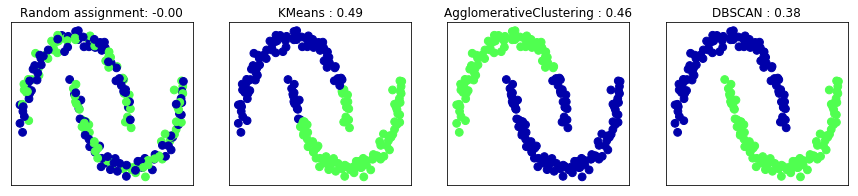

In [5]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# Create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# Plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

As you can see, k-means gets the highest silhouette score, even though we might prefer the result produced by DBSCAN. A slightly better strategy for evaluating clusters is using robustness-based clustering metrics. These run an algorithm after adding some noise to the data, or using different parameter settings, and compare the outcomes. The idea is that if many algorithm parameters and many perturbations of the data return the same result, it is likely to be trustworthy. 

Unfortunately, this strategy is not implemented in scikit-learn at the time of writing.

Even if we get a very robust clustering, or a very high silhouette score, we still don’t know if there is any semantic meaning in the clustering, or whether the clustering reflects an aspect of the data that we are interested in. 

Let’s go back to the example of face images. We hope to find groups of similar faces—say, men and women, or old people and young people, or people with beards and without. Let’s say we cluster the data into two clusters, and all algorithms agree about which points should be clustered together. We still don’t know if the clusters that are found correspond in any way to the concepts we are interested in. It could be that they found side views versus front views, or pictures taken at night versus pictures taken during the day, or pictures taken with iPhones versus pictures taken with Android phones. The only way to know whether the clustering corresponds to anything we are interested in is to analyze the clusters manually.

### Comparing Algorithms on the Faces Dataset

Let’s apply the k-means, DBSCAN, and agglomerative clustering algorithms to the *Labeled Faces in the Wild* dataset, and see if any of them find interesting structure. We will use the eigenface representation of the data, as produced by *PCA(whiten=True)*, with 100 components:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# Scale the grayscale values to be between 0 and 1
# Instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

In [8]:
# Extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)

We saw earlier that this is a more semantic representation of the face images than the raw pixels. It will also make computation faster. A good exercise would be for you to run the following experiments on the original data, without PCA, and see if you find similar clusters.

#### Analyzing the faces dataset with DBSCAN

We will start by applying DBSCAN, which we just discussed:

In [9]:
# Apply DBSCAN with default parameters
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


We see that all the returned labels are –1, so all of the data was labeled as “noise” by DBSCAN. There are two things we can change to help this: we can make *eps* higher, to expand the neighborhood of each point, and set *min_samples* lower, to consider smaller groups of points as clusters. Let’s try changing *min_samples* first:

In [10]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


Even when considering groups of three points, everything is labeled as noise. So, we need to increase *eps*:

In [11]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


Using a much larger *eps* of 15, we get only a single cluster and noise points. We can use this result to find out what the “noise” looks like compared to the rest of the data. To understand better what’s happening, let’s look at how many points are noise, and how many points are inside the cluster:

In [12]:
# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  32 2031]


There are very few noise points—only 27—so we can look at all of them:

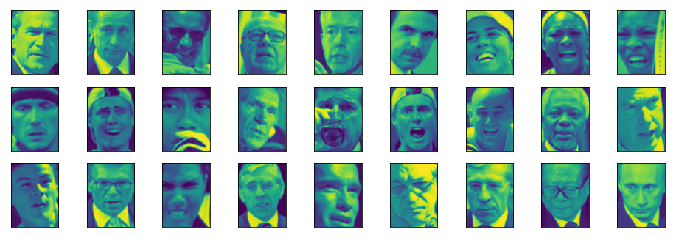

In [13]:
noise = X_people[labels==-1]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

Comparing these images to the random sample of face images from, we can guess why they were labeled as noise: the fifth image in the first row shows a person drinking from a glass, there are images of people wearing hats, and in the last image there’s a hand in front of the person’s face. The other images contain odd angles or crops that are too close or too wide.

This kind of analysis—trying to find “the odd one out”—is called *outlier detection*. If this was a real application, we might try to do a better job of cropping images, to get more homogeneous data. There is little we can do about people in photos sometimes wearing hats, drinking, or holding something in front of their faces, but it’s good to know that these are issues in the data that any algorithm we might apply needs to handle.

If we want to find more interesting clusters than just one large one, we need to set *eps* smaller, somewhere between 15 and 0.5 (the default). Let’s have a look at what different values of *eps* result in:

In [14]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Number of clusters: 1
Cluster sizes: [2063]

eps=3
Number of clusters: 1
Cluster sizes: [2063]

eps=5
Number of clusters: 1
Cluster sizes: [2063]

eps=7
Number of clusters: 14
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Number of clusters: 4
Cluster sizes: [1307  750    3    3]

eps=11
Number of clusters: 2
Cluster sizes: [ 413 1650]

eps=13
Number of clusters: 2
Cluster sizes: [ 120 1943]


For low settings of *eps*, all points are labeled as noise. For *eps=7*, we get many noise points and many smaller clusters. For *eps=9* we still get many noise points, but we get one big cluster and some smaller clusters. Starting from *eps=11*, we get only one large cluster and noise.

What is interesting to note is that there is never more than one large cluster. At most, there is one large cluster containing most of the points, and some smaller clusters. This indicates that there are not two or three different kinds of face images in the data that are very distinct, but rather that all images are more or less equally similar to (or dissimilar from) the rest.

The results for *eps=7* look most interesting, with many small clusters. We can investigate this clustering in more detail by visualizing all of the points in each of the 13 small clusters:

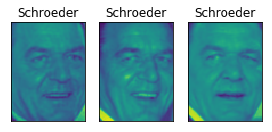

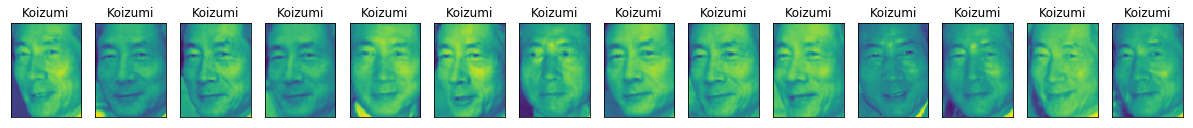

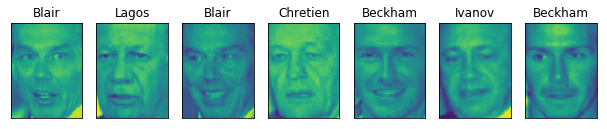

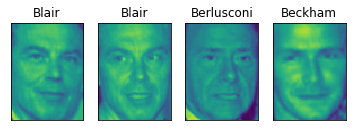

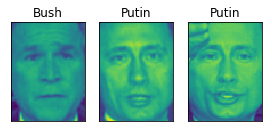

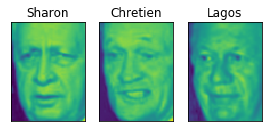

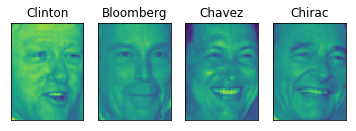

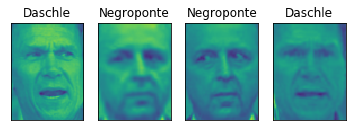

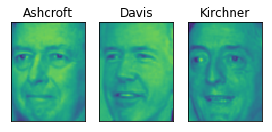

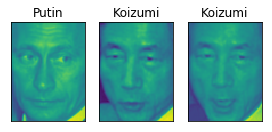

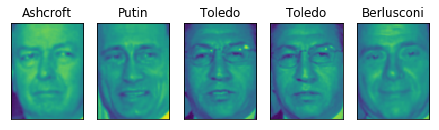

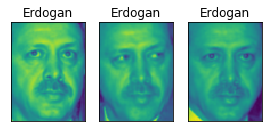

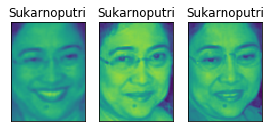

In [15]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):

        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

Some of the clusters correspond to people with very distinct faces (within this dataset), such as Sharon or Koizumi. Within each cluster, the orientation of the face is also quite fixed, as well as the facial expression. Some of the clusters contain faces of multiple people, but they share a similar orientation and expression.

This concludes our analysis of the DBSCAN algorithm applied to the faces dataset. As you can see, we are doing a manual analysis here, different from the much more automatic search approach we could use for supervised learning based on R2 score or accuracy.

#### Analyzing the faces dataset with k-means

We saw that it was not possible to create more than one big cluster using DBSCAN. Agglomerative clustering and k-means are much more likely to create clusters of even size, but we do need to set a target number of clusters. We could set the number of clusters to the known number of people in the dataset, though it is very unlikely that an unsupervised clustering algorithm will recover them. 

Instead, we can start with a low number of clusters, like 10, which might allow us to analyze each of the clusters:

In [16]:
# Extract clusters with k-means
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [155 175 238  75 358 257  91 219 323 172]


As you can see, k-means clustering partitioned the data into relatively similarly sized clusters from 64 to 386. This is quite different from the result of DBSCAN.

We can further analyze the outcome of k-means by visualizing the cluster centers. As we clustered in the representation produced by PCA, we need to rotate the cluster centers back into the original space to visualize them, using *pca.inverse_transform*:

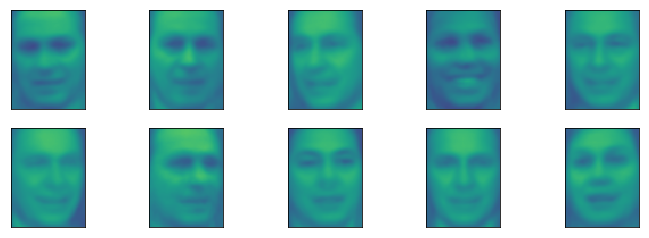

In [18]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))

for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)

The cluster centers found by k-means are very smooth versions of faces. This is not very surprising, given that each center is an average of 64 to 386 face images. Working with a reduced PCA representation adds to the smoothness of the images (compared to the faces reconstructed using 100 PCA dimensions in Figure 3-11). The clustering seems to pick up on different orientations of the face, different expressions (the third cluster center seems to show a smiling face), and the presence of shirt collars (see the second-to-last cluster center).

For a more detailed view, here we show for each cluster center the five most typical images in the cluster (the images assigned to the cluster that are closest to the cluster center) and the five most atypical images in the cluster (the images assigned to the cluster that are furthest from the cluster center):

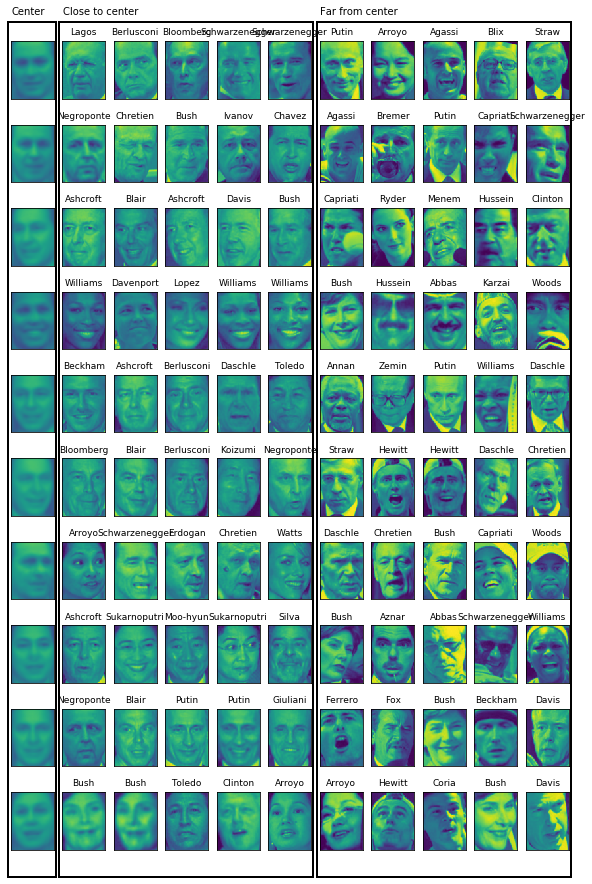

In [19]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people,
                                y_people, people.target_names)

This confirms our intuition about smiling faces for the third cluster, and also the importance of orientation for the other clusters. The “atypical” points are not very similar to the cluster centers, though, and their assignment seems somewhat arbitrary. This can be attributed to the fact that k-means partitions all the data points and doesn’t have a concept of “noise” points, as DBSCAN does. Using a larger number of clusters, the algorithm could find finer distinctions. However, adding more clusters makes manual inspection even harder.

#### Analyzing the faces dataset with agglomerative clustering

Now, let’s look at the results of agglomerative clustering:

In [20]:
# Extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("Cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

Cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]
